# Let's answer some questions about our spotify

In [323]:
#import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

#for auth
import os
from dotenv import load_dotenv

#for spotify api
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [324]:
#get credentials from .env
load_dotenv()

#set up spotipy
client_id=os.getenv('SPOTIPY_CLIENT_ID')
client_secret=os.getenv('SPOTIPY_CLIENT_SECRET')
redirect_uri=os.getenv('SPOTIPY_REDIRECT_URI')

scope='user-top-read'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                                scope=scope))

# First Question

What percenatge of my top songs are taken up by one artist? How much of a fanboy am I?

<Axes: title={'center': 'Percent of My Top 50 Tracks that an Artist Takes Up'}>

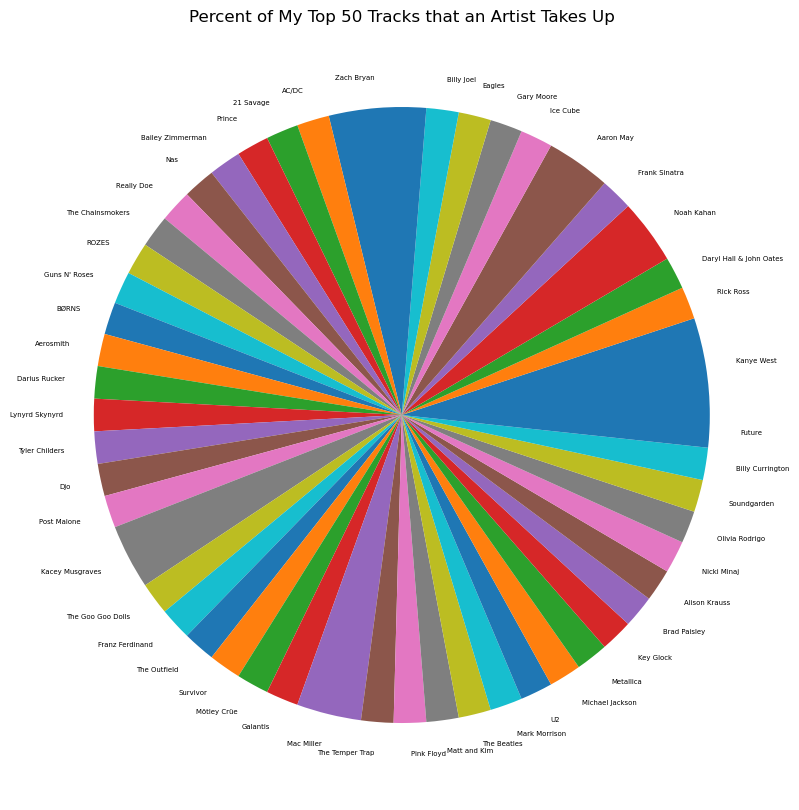

In [325]:

top_tracks_last_year = pd.DataFrame(sp.current_user_top_tracks(limit=50, time_range='long_term')['items'])

#create a series of the 'artists' field  from the top tracks dataframe
all_artists = top_tracks_last_year['artists']

#create a dictionary to store and keep track of # of artist appearances
artist_dict = {}

#count how many times an artist appears in my top 50 tracks over the last year
for song_artists in all_artists:
    for artist in song_artists:
        if artist['name'] not in artist_dict.keys():
            artist_dict[artist['name']] = 1
        else:
            artist_dict[artist['name']] += 1
    
#transform dict to series to plot it
artist_df = pd.DataFrame(artist_dict.items(), columns=['name', 'count']).set_index(['name'])

#add percentage column
artist_df['percentage'] = round(artist_df / artist_df.sum() * 100, 1)

#plot pie chart of percentages
artist_df['percentage'].plot(kind='pie', figsize=(10,10), ylabel='', title='Percent of My Top 50 Tracks that an Artist Takes Up',
                             fontsize=5)

    

# This dataframe is kinda messy. Lets clean it up

In [ ]:
#set name of song to index
top_tracks_last_year = top_tracks_last_year.set_index('name')

#list artists in artist field
top_tracks_last_year['artists'] = top_tracks_last_year['artists'].apply(lambda x: [artist['name'] for artist in x])

#list album in albums field
top_tracks_last_year['album'] = top_tracks_last_year['album'].apply(lambda x: x['name'])

#rid of certain columns
top_tracks_last_year = top_tracks_last_year.drop(columns=['available_markets','disc_number','external_ids',
                                                          'external_urls','href','is_local','preview_url','type','id'])

#change duration_ms to actual time
def ms_to_minutes(ms):
    min = math.floor(ms / 60000)
    sec = math.floor((ms / 60000 - math.floor(ms / 60000)) * 60)
    if sec >= 10:
        time = "%d:%d" % (min,sec)
    else:
        time = "%d:0%d" % (min,sec)
    return time

top_tracks_last_year['duration_ms'] = top_tracks_last_year['duration_ms'].apply(lambda ms: ms_to_minutes(ms=ms) )


#rename some columns
top_tracks_last_year = top_tracks_last_year.rename(columns={'duration_ms':'time'})
top_tracks_last_year.index.name = 'song'

top_tracks_last_year
 

# Ok Second Question

Do I seem to like intro songs more than others? (First song on an album)

<Axes: xlabel='track_number'>

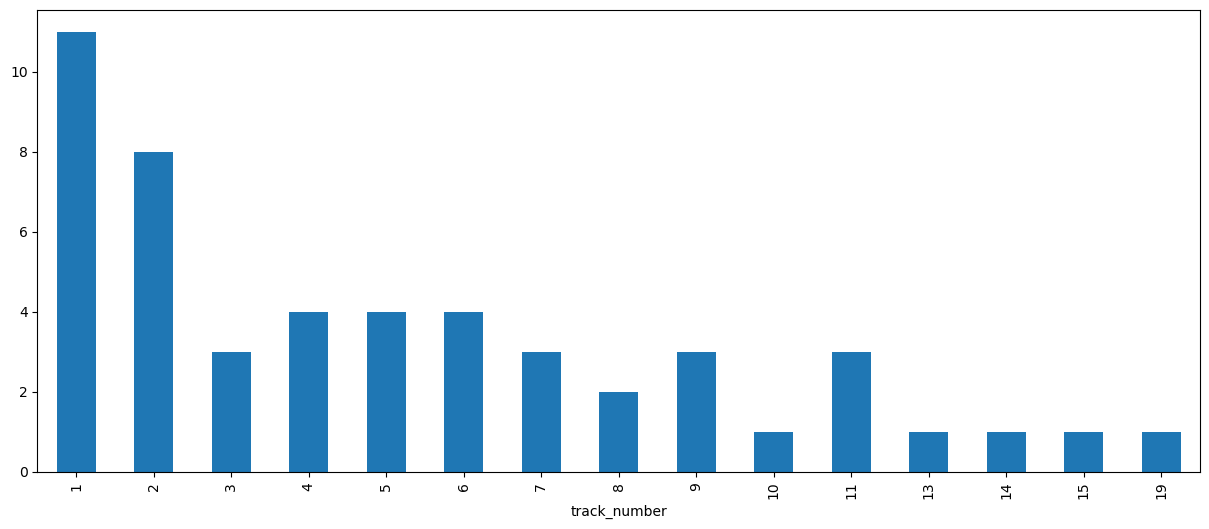

In [329]:
#create Series of # of times each track number shows up in my top tracks (sort by ascending track number)
track_number = top_tracks_last_year['track_number'].value_counts().sort_index()

#barplot these numbers
track_number.plot(kind='bar', figsize=(15,6))


# Small sample size but wow

This leads me to a new question. Do artists front load albums? Do they put all their best songs at the start of an album? I will try to find the answer to this question by using the popularity scores that sporify gives to songs. If I find a correlation, this also raises the question: are the artists actually front loading the albums or are fans influenced by the placement of a track on an album?